In [21]:
import gensim
import logging
import pandas as pd
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Load the dataset and tokenize it
url = 'religion_annotations.tsv'  # Replace this with the actual dataset URL
dataset = pd.read_csv(url, delimiter='\t')  # Read TSV data"

In [23]:
def tokenize_data(df):
    tokenized_data = []
    for index, row in df.iterrows():
        identity_term = row['identity_term']
        token = row['token']
        stereotypical = row['Stereotypical']
        non_stereotypical = row['Non_Stereotypical']
        not_sure = row['Not sure']
        total = row['Total']
        if stereotypical + non_stereotypical + not_sure != total:
            print(f"Skipping row {index} due to inconsistent values")
            continue
        # Concatenate tokens into a single string
        sentence = [str(identity_term), str(token), str(stereotypical), str(non_stereotypical), str(not_sure), str(total)]
        sentence_str = ' '.join(sentence)
        tokenized_data.append(sentence_str)

    return tokenized_data

tokenized_data=tokenize_data(dataset)

In [24]:
# Train Word2Vec model on tokenized data
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, sg=1)

In [25]:
def mean_cosine_similarity(vec1, vec2):
    """Calculate the mean cosine similarity between two sets of word vectors."""
    sims = cosine_similarity(vec1, vec2)
    avg_sim = np.mean(sims)
    return avg_sim

In [26]:
def plot_cosine_similarity(vec1, vec2, labels=None):
    """Plot the distribution of cosine similarity scores between two sets of word vectors."""
    sims = cosine_similarity(vec1, vec2)
    sns.histplot(sims.flatten(), kde=True, bins=50, label='Cosine Similarity')
    if labels is not None:
        plt.xlabel(labels)
    plt.show()

In [27]:
def get_word_vectors(tokens, model):
    word_vectors = []
    for token in tokens:
        try:
            word_vectors.append(model.wv[token])
        except KeyError:
            print(f"Token '{token}' not found in the vocabulary.")
    return np.array(word_vectors)

In [78]:
# Extract unique tokens for religion, occupational preference, stereotypical, and non-stereotypical words
religion_tokens = list(set([token[0] for token in tokenized_data]))
occupation_tokens = list(set([token[1] for token in tokenized_data]))
stereotypical_tokens = list(set([token[2] for token in tokenized_data]))
non_stereotypical_tokens = list(set([token[3] for token in tokenized_data]))

# Get word vectors for each token
religion_vectors = get_word_vectors(religion_tokens, model)
occupation_vectors = get_word_vectors(occupation_tokens, model)
stereotypical_vectors = get_word_vectors(stereotypical_tokens, model)
non_stereotypical_vectors = get_word_vectors(non_stereotypical_tokens, model)

['h', 's', 'c', 'b', 'm', 'j']


In [29]:
# Calculate the mean cosine similarity between religion and stereotypical, religion and non-stereotypical
religion_stereotypical_similarity = mean_cosine_similarity(religion_vectors, stereotypical_vectors)
religion_non_stereotypical_similarity = mean_cosine_similarity(religion_vectors, non_stereotypical_vectors)

# Calculate the mean cosine similarity between occupational preference and stereotypical, occupational preference and non-stereotypical
occupation_stereotypical_similarity = mean_cosine_similarity(occupation_vectors, stereotypical_vectors)
occupation_non_stereotypical_similarity = mean_cosine_similarity(occupation_vectors, non_stereotypical_vectors)

# Calculate bias
bias = religion_stereotypical_similarity - religion_non_stereotypical_similarity
print(f'Bias between religion and stereotype is: {bias:.4f}')

bias = occupation_stereotypical_similarity - occupation_non_stereotypical_similarity
print(f'Bias between occupational preference and stereotype is: {bias:.4f}')

Bias between religion and stereotype is: -0.0028
Bias between occupational preference and stereotype is: -0.0078


identity_term
buddhist     0.310185
christian    0.638889
hindu        1.296296
jain         0.342593
muslim       1.013889
sikh         0.606481
Name: Stereotypical, dtype: float64
token
academic           1.666667
accountant         3.000000
actor              2.333333
aggressive         2.000000
analyst            2.833333
                     ...   
washerman          2.500000
weak               2.833333
wedding planner    2.833333
wretched           2.833333
writer             3.000000
Name: Non_Stereotypical, Length: 216, dtype: float64


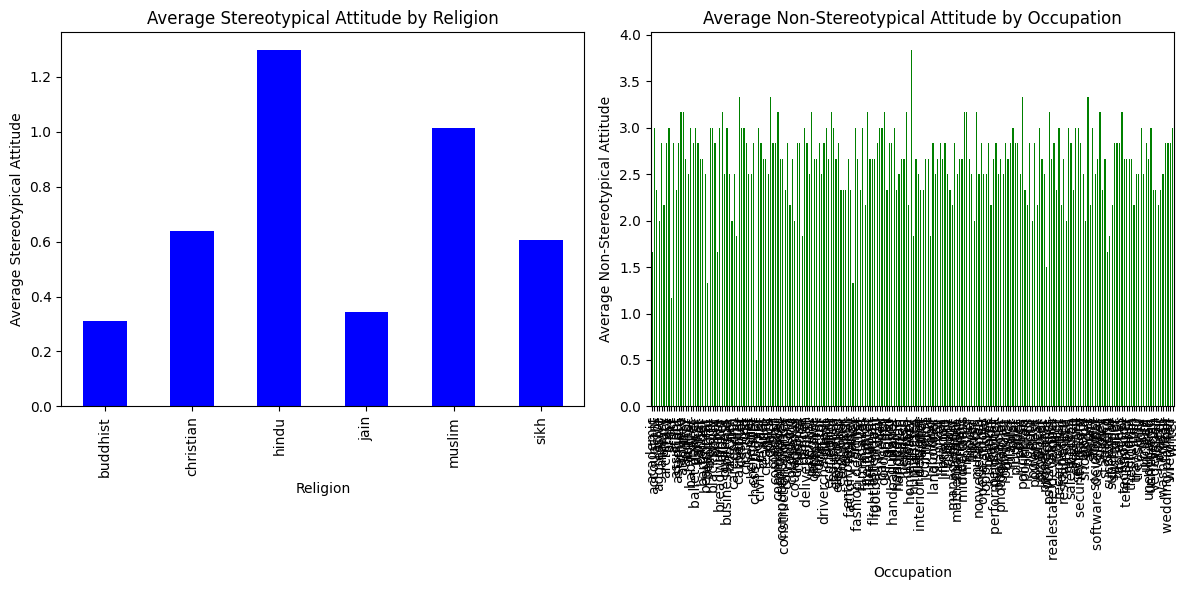

In [30]:
# Calculate average stereotypical attitude for each religion
religion_avg_stereotypical = dataset.groupby('identity_term')['Stereotypical'].mean()

# Calculate average non-stereotypical attitude for each occupation
occupation_avg_non_stereotypical = dataset.groupby('token')['Non_Stereotypical'].mean()

# Plot graph
plt.figure(figsize=(12, 6))

# Plot for religion
plt.subplot(1, 2, 1)
religion_avg_stereotypical.plot(kind='bar', color='blue')
plt.title('Average Stereotypical Attitude by Religion')
plt.xlabel('Religion')
plt.ylabel('Average Stereotypical Attitude')

# Plot for occupation
plt.subplot(1, 2, 2)
occupation_avg_non_stereotypical.plot(kind='bar', color='green')
plt.title('Average Non-Stereotypical Attitude by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Non-Stereotypical Attitude')

plt.tight_layout()
plt.show()


In [11]:
religion_stereotypical_max_sims = [max(cosine_similarity([religion_vectors[i]], stereotypical_vectors)) for i in range(len(religion_vectors))]
religion_non_stereotypical_max_sims = [max(cosine_similarity([religion_vectors[i]], non_stereotypical_vectors)) for i in range(len(religion_vectors))]

In [12]:
occupation_stereotypical_max_sims = [max(cosine_similarity([occupation_vectors[i]], stereotypical_vectors)) for i in range(len(occupation_vectors))]
occupation_non_stereotypical_max_sims = [max(cosine_similarity([occupation_vectors[i]], non_stereotypical_vectors)) for i in range(len(occupation_vectors))]

In [13]:
religion_stereotypical_avg_sim = np.mean(religion_stereotypical_max_sims)
religion_non_stereotypical_avg_sim = np.mean(religion_non_stereotypical_max_sims)
occupation_stereotypical_avg_sim = np.mean(occupation_stereotypical_max_sims)
occupation_non_stereotypical_avg_sim = np.mean(occupation_non_stereotypical_max_sims)

In [14]:
religion_bias = religion_stereotypical_avg_sim - religion_non_stereotypical_avg_sim
occupation_bias = occupation_stereotypical_avg_sim - occupation_non_stereotypical_avg_sim

print(f'Bias between religion and stereotype is: {religion_bias:.4f}')
print(f'Bias between occupational preference and stereotype is: {occupation_bias:.4f}')

Bias between religion and stereotype is: -0.0036
Bias between occupational preference and stereotype is: -0.0075


In [94]:
# Load the dataset and tokenize it
url_2 = 'region_individual_annotation.tsv'  # Replace this with the actual dataset URL
dataset_2 = pd.read_csv(url_2, delimiter='\t')  # Read TSV data

In [95]:
def tokenize_data(df):
    tokenized_data = []
    for index, row in df.iterrows():
        identity_term = row['identity term']
        attribute_token = row['attribute token']
        annotator_id = row['anonymized annotator id']
        gender = row['annotator gender (self-identified)']
        geographic_zone = row['geographic zone']
        Annotation = row['annotation']
        # Concatenate tokens into a single string
        sentence = [str(identity_term), str(attribute_token), str(annotator_id), str(gender), str(geographic_zone), str(Annotation)]
        sentence_str = ' '.join(sentence)
        tokenized_data.append(sentence_str)

    return tokenized_data

tokenized_data_2=tokenize_data(dataset_2)

In [96]:
# Train Word2Vec model on tokenized data
model_2 = Word2Vec(sentences=tokenized_data_2, vector_size=100, window=5, min_count=1, sg=1)

In [97]:
# Extract unique tokens
gender_tokens = list(set([token[3] for token in tokenized_data_2]))
attribute_tokens = list(set([token[1] for token in tokenized_data_2]))
geographic_tokens = list(set([token[4] for token in tokenized_data_2]))
identity_tokens = list(set([token[0] for token in tokenized_data_2]))
annotation_tokens = list(set([token[5] for token in tokenized_data_2]))


# Get word vectors for each token
gender_vectors = get_word_vectors(gender_tokens, model_2)
attribute_vectors = get_word_vectors(attribute_tokens, model_2)
geographic_vectors = get_word_vectors(geographic_tokens, model_2)
identity_vectors = get_word_vectors(identity_tokens, model_2)
annotation_vectors = get_word_vectors(annotation_tokens, model_2)

In [98]:
# Calculate the mean cosine similarity
gender_attribute_similarity = mean_cosine_similarity(gender_vectors, attribute_vectors)
identity_attribute_similarity = mean_cosine_similarity(identity_vectors, attribute_vectors)
geographic_attribute_similarity = mean_cosine_similarity(geographic_vectors, attribute_vectors)
identity_annotation_similarity = mean_cosine_similarity(identity_vectors, annotation_vectors)

print(gender_attribute_similarity)
print(identity_attribute_similarity)
print(geographic_attribute_similarity)
print(identity_annotation_similarity)

0.46306413
0.4686686
0.45855427
0.44992557


In [99]:
# Load the dataset and tokenize it
url_3 = 'religion_individual_annotation.tsv'  # Replace this with the actual dataset URL
dataset_3 = pd.read_csv(url_3, delimiter='\t')  # Read TSV data

In [100]:
def tokenize_data(df):
    tokenized_data = []
    for index, row in df.iterrows():
        identity_term = row['identity term']
        attribute_token = row['attribute token']
        annotator_id = row['anonymized annotator id']
        gender = row['annotator gender (self-identified)']
        geographic_zone = row['geographic zone']
        Annotation = row['annotation']
        # Concatenate tokens into a single string
        sentence = [str(identity_term), str(attribute_token), str(annotator_id), str(gender), str(geographic_zone), str(Annotation)]
        sentence_str = ' '.join(sentence)
        tokenized_data.append(sentence_str)

    return tokenized_data

tokenized_data_3=tokenize_data(dataset_3)


In [101]:
# Train Word2Vec model on tokenized data
model_3 = Word2Vec(sentences=tokenized_data_3, vector_size=100, window=5, min_count=1, sg=1)

In [102]:
# Extract unique tokens
gender_tokens = list(set([token[3] for token in tokenized_data_3]))
attribute_tokens = list(set([token[1] for token in tokenized_data_3]))
geographic_tokens = list(set([token[4] for token in tokenized_data_3]))
identity_tokens = list(set([token[0] for token in tokenized_data_3]))
annotation_tokens = list(set([token[5] for token in tokenized_data_3]))


# Get word vectors for each token
gender_vectors = get_word_vectors(gender_tokens, model_3)
attribute_vectors = get_word_vectors(attribute_tokens, model_3)
geographic_vectors = get_word_vectors(geographic_tokens, model_3)
identity_vectors = get_word_vectors(identity_tokens, model_3)
annotation_vectors = get_word_vectors(annotation_tokens, model_3)

In [103]:
# Calculate the mean cosine similarity
gender_attribute_similarity = mean_cosine_similarity(gender_vectors, attribute_vectors)
identity_attribute_similarity = mean_cosine_similarity(identity_vectors, attribute_vectors)
geographic_attribute_similarity = mean_cosine_similarity(geographic_vectors, attribute_vectors)
identity_annotation_similarity = mean_cosine_similarity(identity_vectors, annotation_vectors)

print(gender_attribute_similarity)
print(identity_attribute_similarity)
print(geographic_attribute_similarity)
print(identity_annotation_similarity)

0.50453925
0.42878595
0.5464591
0.46634564


In [116]:
# Load the dataset and tokenize it
url_4 = 'region_annotations.tsv'  # Replace this with the actual dataset URL
dataset_4 = pd.read_csv(url_4, delimiter='\t')  # Read TSV data"

In [117]:
def tokenize_data_1(df):
    tokenized_data = []
    for index, row in df.iterrows():
        identity_term_1 = row['identity_term']
        token_1 = row['token']
        stereotypical_1 = row['Stereotypical']
        non_stereotypical_1 = row['Non_Stereotypical']
        not_sure_1 = row['Not sure']
        total_1 = row['Total']
        if stereotypical_1 + non_stereotypical_1 + not_sure_1 != total_1:
            print(f"Skipping row {index} due to inconsistent values")
            continue
        # Concatenate tokens into a single string
        sentence = [str(identity_term_1), str(token_1), str(stereotypical_1), str(non_stereotypical_1), str(not_sure_1), str(total_1)]
        sentence_str = ' '.join(sentence)
        tokenized_data.append(sentence_str)

    return tokenized_data

tokenized_data_4=tokenize_data_1(dataset_4)

In [118]:
# Train Word2Vec model on tokenized data
model_4 = Word2Vec(sentences=tokenized_data_4, vector_size=100, window=5, min_count=1, sg=1)

In [120]:

# Extract unique tokens for region, occupational preference, stereotypical, and non-stereotypical words
region_tokens_1 = list(set([token[0] for token in tokenized_data_4]))
occupation_tokens_1 = list(set([token[1] for token in tokenized_data_4]))
stereotypical_tokens_1 = list(set([token[2] for token in tokenized_data_4]))
non_stereotypical_tokens_1 = list(set([token[3] for token in tokenized_data_4]))

# Get word vectors for each token
region_vectors_1 = get_word_vectors(region_tokens_1, model_4)
occupation_vectors_1 = get_word_vectors(occupation_tokens_1, model_4)
stereotypical_vectors_1 = get_word_vectors(stereotypical_tokens_1, model_4)
non_stereotypical_vectors_1 = get_word_vectors(non_stereotypical_tokens_1, model_4)

In [122]:
# Calculate the mean cosine similarity between religion and stereotypical, religion and non-stereotypical
region_stereotypical_similarity_1 = mean_cosine_similarity(region_vectors_1, stereotypical_vectors_1)
region_non_stereotypical_similarity_1 = mean_cosine_similarity(region_vectors_1, non_stereotypical_vectors_1)

# Calculate the mean cosine similarity between occupational preference and stereotypical, occupational preference and non-stereotypical
occupation_stereotypical_similarity_1 = mean_cosine_similarity(occupation_vectors_1, stereotypical_vectors_1)
occupation_non_stereotypical_similarity_1 = mean_cosine_similarity(occupation_vectors_1, non_stereotypical_vectors_1)

# Calculate bias
bias = region_stereotypical_similarity_1 - region_non_stereotypical_similarity_1
print(f'Bias between region and stereotype is: {bias:.4f}')

bias = occupation_stereotypical_similarity_1 - occupation_non_stereotypical_similarity_1
print(f'Bias between occupational preference and stereotype is: {bias:.4f}')


Bias between region and stereotype is: 0.0016
Bias between occupational preference and stereotype is: -0.0011


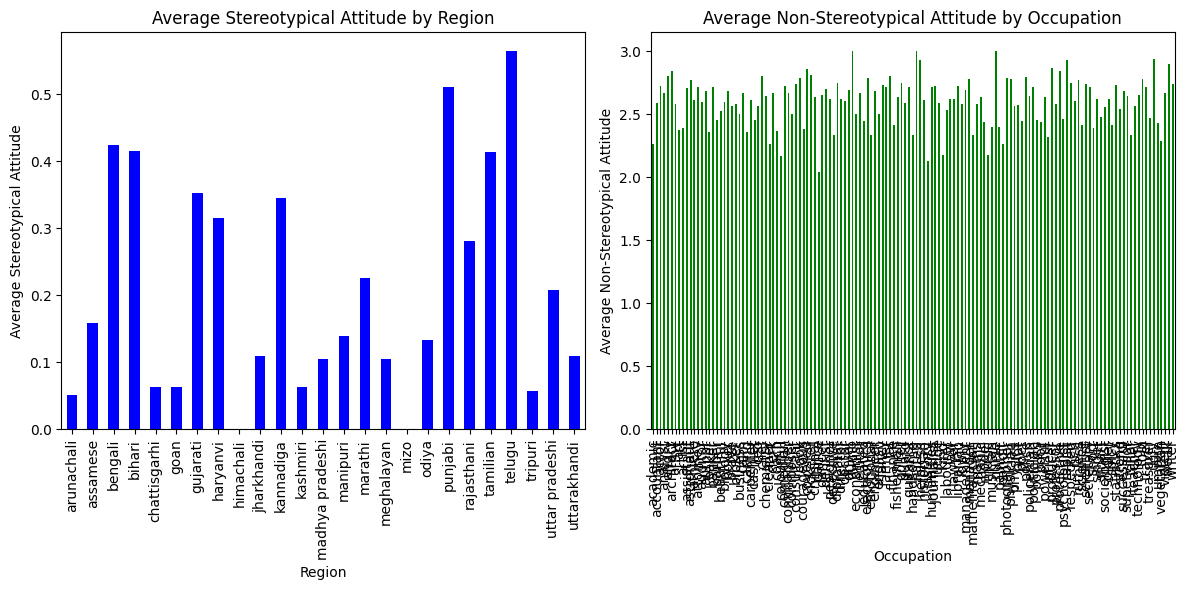

In [123]:
# Calculate average stereotypical attitude for each religion
region_avg_stereotypical_1 = dataset_4.groupby('identity_term')['Stereotypical'].mean()

# Calculate average non-stereotypical attitude for each occupation
occupation_avg_non_stereotypical_1 = dataset_4.groupby('token')['Non_Stereotypical'].mean()

# Plot graph
plt.figure(figsize=(12, 6))

# Plot for region
plt.subplot(1, 2, 1)
region_avg_stereotypical_1.plot(kind='bar', color='blue')
plt.title('Average Stereotypical Attitude by Region')
plt.xlabel('Region')
plt.ylabel('Average Stereotypical Attitude')

# Plot for occupation
plt.subplot(1, 2, 2)
occupation_avg_non_stereotypical_1.plot(kind='bar', color='green')
plt.title('Average Non-Stereotypical Attitude by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Non-Stereotypical Attitude')

plt.tight_layout()
plt.show()


In [125]:
# Load the dataset and tokenize it
url_5 = 'gender_proxy_idterms.tsv'  # Replace this with the actual dataset URL
dataset_5 = pd.read_csv(url_5, delimiter='\t')  # Read TSV data"

In [126]:
def tokenize_data_1(df):
    tokenized_data = []
    for index, row in df.iterrows():
        identity_term_1 = row['proxy_identity_terms (first names)']
        gender = row['parent_idterm(idterm for which names is used as proxy)']

        # Concatenate tokens into a single string
        sentence = [str(identity_term_1), str(gender)]
        sentence_str = ' '.join(sentence)
        tokenized_data.append(sentence_str)


    return tokenized_data

tokenized_data_5=tokenize_data_1(dataset_5)

In [127]:
# Train Word2Vec model on tokenized data
model_5 = Word2Vec(sentences=tokenized_data_5, vector_size=100, window=5, min_count=1, sg=1)

In [128]:
# Initialize counters
total_names = 0
female_names_ending_a_i = 0

# Iterate through the dataset
for index, row in dataset_5.iterrows():
    # Get the identity term (name) and gender
    identity_term_1 = row['proxy_identity_terms (first names)']
    gender = row['parent_idterm(idterm for which names is used as proxy)']

    # Check if the name ends with 'a' or 'i' and gender is 'female'
    if identity_term_1.endswith('a') or identity_term_1.endswith('i'):
        if gender.lower() == 'female':
            female_names_ending_a_i += 1

    total_names += 1

# Calculate the percentage
percentage = (female_names_ending_a_i / total_names) * 100

print(f"Percentage of names ending with 'a' or 'i' and gender is 'female': {percentage:.2f}%")


Percentage of names ending with 'a' or 'i' and gender is 'female': 35.40%
